In [1]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
import tensorflow.keras as keras

from tensorflow.keras import layers, models, optimizers, losses

from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.layers import (Flatten, Dense, Conv2D, MaxPooling2D, 
                                    Concatenate, Dot, Lambda, Dropout, ZeroPadding2D, Activation, concatenate, add,
                                    BatchNormalization, Conv1D, GlobalAveragePooling2D, InputLayer, Input)

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import binary_crossentropy, sparse_categorical_crossentropy, categorical_crossentropy

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard

from tensorflow.keras import backend as K

import tensorflow.keras.utils as utils
from tensorflow.keras.utils import plot_model, to_categorical

from tensorflow.keras.applications import DenseNet201

from tensorflow.keras.datasets import mnist, fashion_mnist

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

___

# Implement VGG Module (Visual Geometry Group)

In [110]:
K.clear_session()

In [106]:
def vgg_block(layer_in, n_filters, n_conv):
    for _ in range(n_conv):
        layer_in=Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in

In [109]:
def vgg_block(layer_in, n_filters, n_conv, i):
    
    for j in range(n_conv):
        layer_in=Conv2D(n_filters, (3,3), padding='same', activation='relu', name=f"block{i}_conv{i+j}")(layer_in)
    
    layer_in = MaxPooling2D((2,2), strides=(2,2), name=f"block{i}_pool")(layer_in)
    
    return layer_in

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


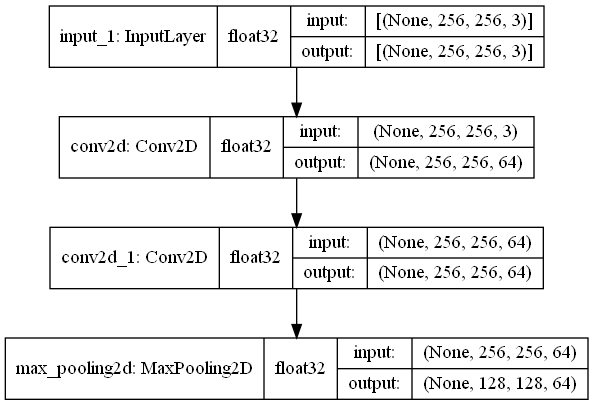

In [108]:
# define model input
visible = Input(shape=(256, 256, 3))
# add vgg module
layer = vgg_block(visible, 64, 2)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, to_file='1-vgg_block.png', show_shapes=True, show_layer_names=True, show_dtype=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv3 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

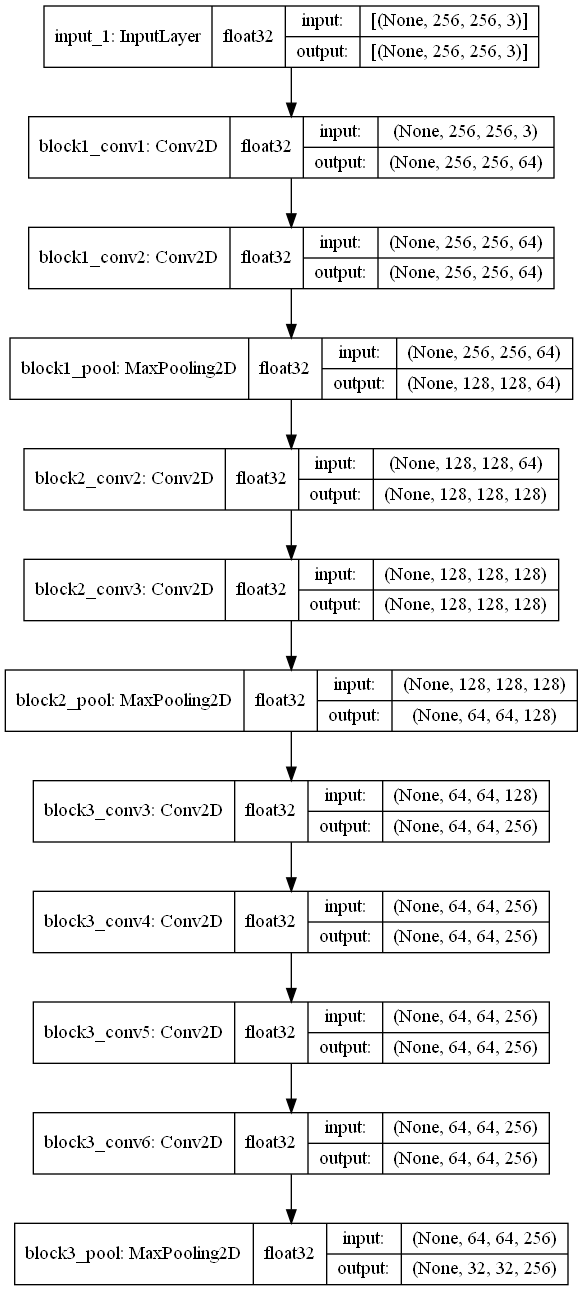

In [111]:
# define model input
visible = Input(shape=(256, 256, 3))
# add vgg module
layer = vgg_block(visible, 64, 2, 1)
# add vgg module
layer = vgg_block(layer, 128, 2, 2)
# add vgg module
layer = vgg_block(layer, 256, 4, 3)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, to_file='1-multiple_vgg_blocks.png', show_shapes=True, show_layer_names=True, show_dtype=True)

In [112]:
model.layers

In [113]:
model.layers[1].name

'block1_conv1'

# Implement Inception Module

In [8]:
K.clear_session()

In [9]:
def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 2432        input_1[0][0]                    
______________________________________________________________________________________________

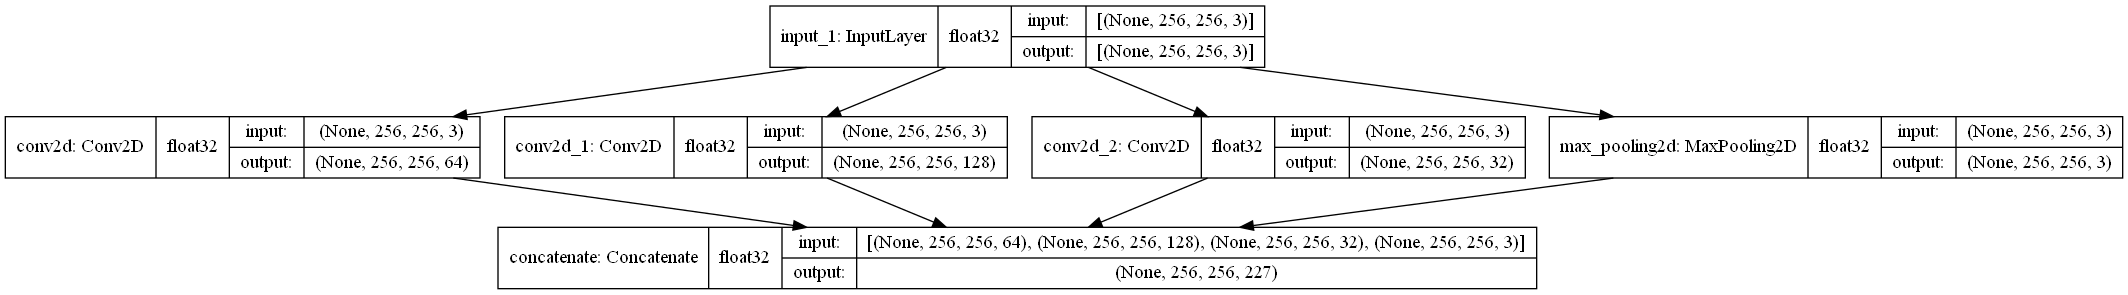

In [7]:
# define model input
visible = Input(shape=(256, 256, 3))
# add inception module
layer = naive_inception_module(visible, 64, 128, 32)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, to_file='2-naive_inception_module.png', show_shapes=True, show_layer_names=True, show_dtype=True)

In [11]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 96) 384         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 16) 64          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 3)  0           input_1[0][0]                    
______________________________________________________________________________________________

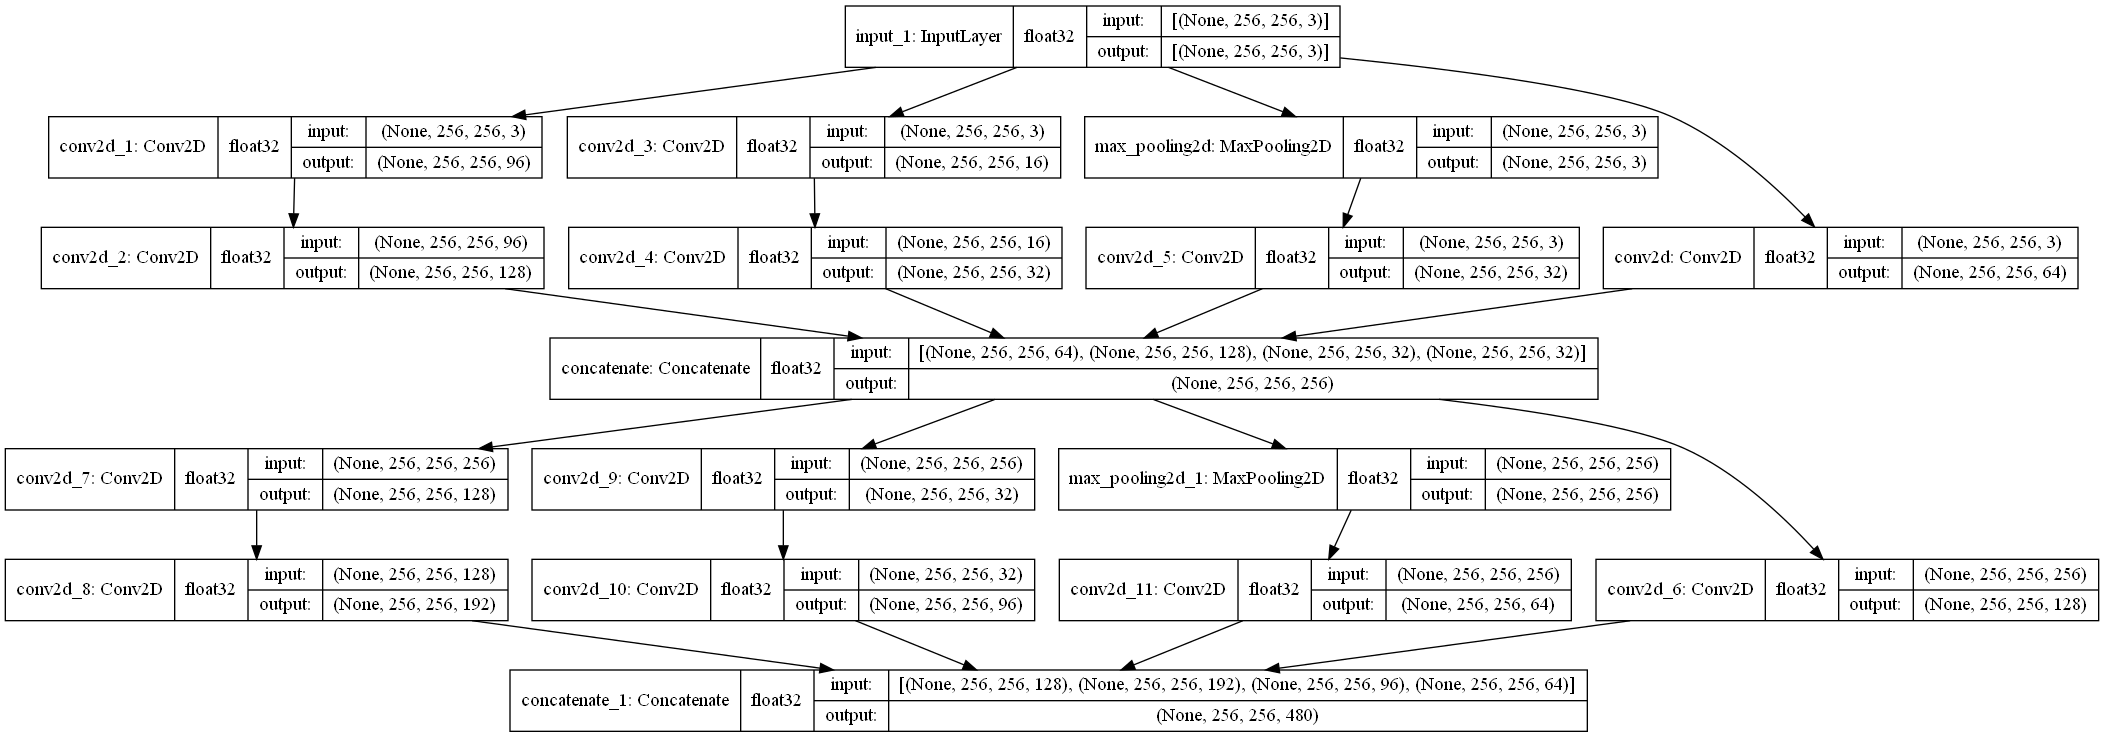

In [12]:
# define model input
visible = Input(shape=(256, 256, 3))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# add inception block 1
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, to_file='2-inception_module.png', show_shapes=True, show_layer_names=True, show_dtype=True)

# Implement the Residual Module

In [23]:
K.clear_session()

In [20]:
def residual_module(layer_in, n_filters):
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu',   kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = add([conv2, layer_in])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

In [22]:
# define model input
visible = Input(shape=(256, 256, 3))
# add vgg module
layer = residual_module(visible, 64)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, to_file='3-residual_module_1.png', show_shapes=True, show_layer_names=True, show_dtype=True)

ValueError: Operands could not be broadcast together with shapes (256, 256, 64) (256, 256, 3)

In [24]:
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increased, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 256         input_1[0][0]                    
______________________________________________________________________________________________

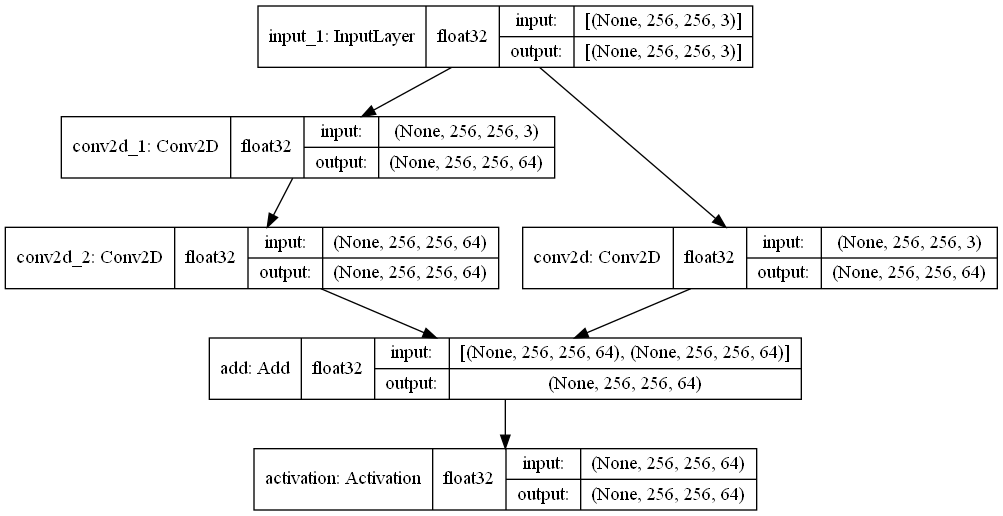

In [25]:
# define model input
visible = Input(shape=(256, 256, 3))
# add vgg module
layer = residual_module(visible, 64)
# create model
model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, to_file='3-residual_module_2.png', show_shapes=True, show_layer_names=True, show_dtype=True)